In [10]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

print("=" * 80)
print("NOTEBOOK 08: POLICY TARGETING FRAMEWORK")
print("=" * 80)
print("\nObjective: Develop cluster-based targeting framework for social policy")
print("Approach: Vulnerability scoring + Priority ranking (NOT accuracy evaluation)")
print("\nNote: This analysis uses aggregate BPS data, not individual household data.")
print("      Therefore, we focus on FRAMEWORK development, not targeting accuracy.")
print("\nLibraries loaded successfully.")

NOTEBOOK 08: POLICY TARGETING FRAMEWORK

Objective: Develop cluster-based targeting framework for social policy
Approach: Vulnerability scoring + Priority ranking (NOT accuracy evaluation)

Note: This analysis uses aggregate BPS data, not individual household data.
      Therefore, we focus on FRAMEWORK development, not targeting accuracy.

Libraries loaded successfully.


In [11]:
# Cell 2: Load Data
df = pd.read_csv('../data/clustered_data.csv')
features_df = pd.read_csv('../data/features_for_clustering.csv')

print("=== DATA LOADED ===")
print(f"Clustered data shape: {df.shape}")
print(f"Features data shape: {features_df.shape}")
print(f"\nCluster distribution:")
print(df['cluster_final'].value_counts().sort_index())
print(f"\nYears covered: {df['year'].min()} - {df['year'].max()}")

=== DATA LOADED ===
Clustered data shape: (102, 38)
Features data shape: (102, 34)

Cluster distribution:
cluster_final
0    79
1    18
2     5
Name: count, dtype: int64

Years covered: 2013 - 2025


## 1. Cluster Characterization for Policy Targeting

Sebelum membuat framework targeting, kita perlu memahami karakteristik setiap cluster dari perspektif kebijakan sosial.

In [12]:
# Cell 3: Cluster Profile Summary
cluster_names = {
    0: 'Stable (Low Volatility)',
    1: 'Volatile (High CV)',
    2: 'Extreme (Very High CV)'
}

# Key metrics per cluster
key_metrics = ['cv_consumption', 'food_ratio', 'nonfood_ratio', 'cv_food', 'cv_nonfood']

print("=" * 80)
print("CLUSTER PROFILES FOR POLICY TARGETING")
print("=" * 80)

for cluster in sorted(df['cluster_final'].unique()):
    cluster_data = df[df['cluster_final'] == cluster]
    print(f"\n{'='*40}")
    print(f"CLUSTER {cluster}: {cluster_names[cluster]}")
    print(f"{'='*40}")
    print(f"  Sample size: {len(cluster_data)} observations")
    print(f"  Proportion: {len(cluster_data)/len(df)*100:.1f}%")
    print(f"\n  Key Characteristics:")
    for metric in key_metrics:
        if metric in cluster_data.columns:
            mean_val = cluster_data[metric].mean()
            print(f"    - {metric}: {mean_val:.3f}")

CLUSTER PROFILES FOR POLICY TARGETING

CLUSTER 0: Stable (Low Volatility)
  Sample size: 79 observations
  Proportion: 77.5%

  Key Characteristics:
    - cv_consumption: 119.769
    - food_ratio: 53.051
    - nonfood_ratio: 46.949

CLUSTER 1: Volatile (High CV)
  Sample size: 18 observations
  Proportion: 17.6%

  Key Characteristics:
    - cv_consumption: 302.820
    - food_ratio: 13.777
    - nonfood_ratio: 86.223

CLUSTER 2: Extreme (Very High CV)
  Sample size: 5 observations
  Proportion: 4.9%

  Key Characteristics:
    - cv_consumption: 242.572
    - food_ratio: 38.908
    - nonfood_ratio: 61.092


In [13]:
# Cell 4: Comparative Analysis - Cluster Means
comparison_metrics = ['cv_consumption', 'food_ratio', 'nonfood_ratio', 
                      'total_consumption', 'biaya_pendidikan', 'biaya_kesehatan']

available_metrics = [m for m in comparison_metrics if m in df.columns]

cluster_comparison = df.groupby('cluster_final')[available_metrics].mean()
cluster_comparison.index = [f"Cluster {i}: {cluster_names[i]}" for i in cluster_comparison.index]

print("=" * 80)
print("CLUSTER COMPARISON (Mean Values)")
print("=" * 80)
print(cluster_comparison.round(3).to_string())

# Statistical difference test
print("\n" + "=" * 80)
print("STATISTICAL SIGNIFICANCE (Kruskal-Wallis Test)")
print("=" * 80)
for metric in available_metrics:
    groups = [df[df['cluster_final'] == c][metric].dropna() for c in df['cluster_final'].unique()]
    if all(len(g) > 0 for g in groups):
        stat, p_value = stats.kruskal(*groups)
        sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"  {metric}: H={stat:.2f}, p={p_value:.4f} {sig}")

CLUSTER COMPARISON (Mean Values)
                                    cv_consumption  food_ratio  nonfood_ratio  total_consumption
Cluster 0: Stable (Low Volatility)         119.769      53.051         46.949         825653.456
Cluster 1: Volatile (High CV)              302.820      13.777         86.223        1165376.333
Cluster 2: Extreme (Very High CV)          242.572      38.908         61.092        1626205.000

STATISTICAL SIGNIFICANCE (Kruskal-Wallis Test)
  cv_consumption: H=53.32, p=0.0000 ***
  food_ratio: H=49.32, p=0.0000 ***
  nonfood_ratio: H=49.32, p=0.0000 ***
  total_consumption: H=12.44, p=0.0020 **


## 2. Vulnerability Scoring System

Membuat skor kerentanan berbasis karakteristik cluster dan fitur-fitur kunci.

In [14]:
# Cell 5: Create Vulnerability Score Components
print("=" * 80)
print("VULNERABILITY SCORING METHODOLOGY")
print("=" * 80)

# Component 1: Cluster-based score (based on volatility risk)
cluster_scores = {0: 20, 1: 60, 2: 100}  # Cluster 2 highest risk
df['score_cluster'] = df['cluster_final'].map(cluster_scores)

# Component 2: CV Consumption (normalized 0-100)
cv_min, cv_max = df['cv_consumption'].min(), df['cv_consumption'].max()
df['score_cv'] = ((df['cv_consumption'] - cv_min) / (cv_max - cv_min)) * 100

# Component 3: Food Ratio (higher = more vulnerable, normalized)
fr_min, fr_max = df['food_ratio'].min(), df['food_ratio'].max()
df['score_food_ratio'] = ((df['food_ratio'] - fr_min) / (fr_max - fr_min)) * 100

# Component 4: Non-food Ratio (lower = more vulnerable, inverted)
nf_min, nf_max = df['nonfood_ratio'].min(), df['nonfood_ratio'].max()
df['score_nonfood'] = (1 - (df['nonfood_ratio'] - nf_min) / (nf_max - nf_min)) * 100

print("\nScoring Components:")
print("  1. Cluster Score (40%): Based on cluster membership")
print("     - Cluster 0 (Stable): 20 points")
print("     - Cluster 1 (Volatile): 60 points")
print("     - Cluster 2 (Extreme): 100 points")
print("\n  2. CV Consumption Score (25%): Normalized consumption volatility")
print("\n  3. Food Ratio Score (20%): Higher food ratio = more vulnerable")
print("\n  4. Non-food Ratio Score (15%): Lower non-food = more vulnerable")

VULNERABILITY SCORING METHODOLOGY

Scoring Components:
  1. Cluster Score (40%): Based on cluster membership
     - Cluster 0 (Stable): 20 points
     - Cluster 1 (Volatile): 60 points
     - Cluster 2 (Extreme): 100 points

  2. CV Consumption Score (25%): Normalized consumption volatility

  3. Food Ratio Score (20%): Higher food ratio = more vulnerable

  4. Non-food Ratio Score (15%): Lower non-food = more vulnerable


In [15]:
# Cell 6: Calculate Composite Vulnerability Score
# Weights based on importance from SHAP analysis
weights = {
    'cluster': 0.40,    # Cluster membership (primary)
    'cv': 0.25,         # CV consumption (SHAP #1)
    'food_ratio': 0.20, # Food ratio (SHAP #2)
    'nonfood': 0.15     # Non-food ratio (SHAP #3)
}

df['vulnerability_score'] = (
    weights['cluster'] * df['score_cluster'] +
    weights['cv'] * df['score_cv'] +
    weights['food_ratio'] * df['score_food_ratio'] +
    weights['nonfood'] * df['score_nonfood']
)

# Create vulnerability categories
df['vulnerability_category'] = pd.cut(
    df['vulnerability_score'],
    bins=[0, 30, 50, 70, 100],
    labels=['Low', 'Moderate', 'High', 'Very High']
)

print("=" * 80)
print("VULNERABILITY SCORE DISTRIBUTION")
print("=" * 80)
print(f"\nScore Range: {df['vulnerability_score'].min():.1f} - {df['vulnerability_score'].max():.1f}")
print(f"Mean Score: {df['vulnerability_score'].mean():.1f}")
print(f"Median Score: {df['vulnerability_score'].median():.1f}")

print("\n" + "-" * 40)
print("Category Distribution:")
print("-" * 40)
print(df['vulnerability_category'].value_counts().sort_index())

VULNERABILITY SCORE DISTRIBUTION

Score Range: 21.4 - 74.1
Mean Score: 35.7
Median Score: 32.1

----------------------------------------
Category Distribution:
----------------------------------------
vulnerability_category
Low          30
Moderate     60
High         10
Very High     2
Name: count, dtype: int64


In [16]:
# Cell 7: Vulnerability Score by Cluster
print("=" * 80)
print("VULNERABILITY SCORE BY CLUSTER")
print("=" * 80)

vuln_by_cluster = df.groupby('cluster_final').agg({
    'vulnerability_score': ['mean', 'std', 'min', 'max', 'count']
}).round(2)
vuln_by_cluster.columns = ['Mean', 'Std', 'Min', 'Max', 'N']
vuln_by_cluster.index = [f"Cluster {i}: {cluster_names[i]}" for i in vuln_by_cluster.index]
print(vuln_by_cluster)

# Cross-tabulation: Cluster vs Vulnerability Category
print("\n" + "-" * 40)
print("Cluster vs Vulnerability Category:")
print("-" * 40)
cross_tab = pd.crosstab(df['cluster_final'], df['vulnerability_category'], margins=True)
cross_tab.index = [f"Cluster {i}" if i != 'All' else 'Total' for i in cross_tab.index]
print(cross_tab)

VULNERABILITY SCORE BY CLUSTER
                                     Mean   Std    Min    Max   N
Cluster 0: Stable (Low Volatility)  31.05  5.05  21.35  44.48  79
Cluster 1: Volatile (High CV)       47.07  4.23  41.49  52.20  18
Cluster 2: Extreme (Very High CV)   68.46  4.42  62.91  74.06   5

----------------------------------------
Cluster vs Vulnerability Category:
----------------------------------------
vulnerability_category  Low  Moderate  High  Very High  All
Cluster 0                30        49     0          0   79
Cluster 1                 0        11     7          0   18
Cluster 2                 0         0     3          2    5
Total                    30        60    10          2  102


## 3. Visualisasi Vulnerability Score

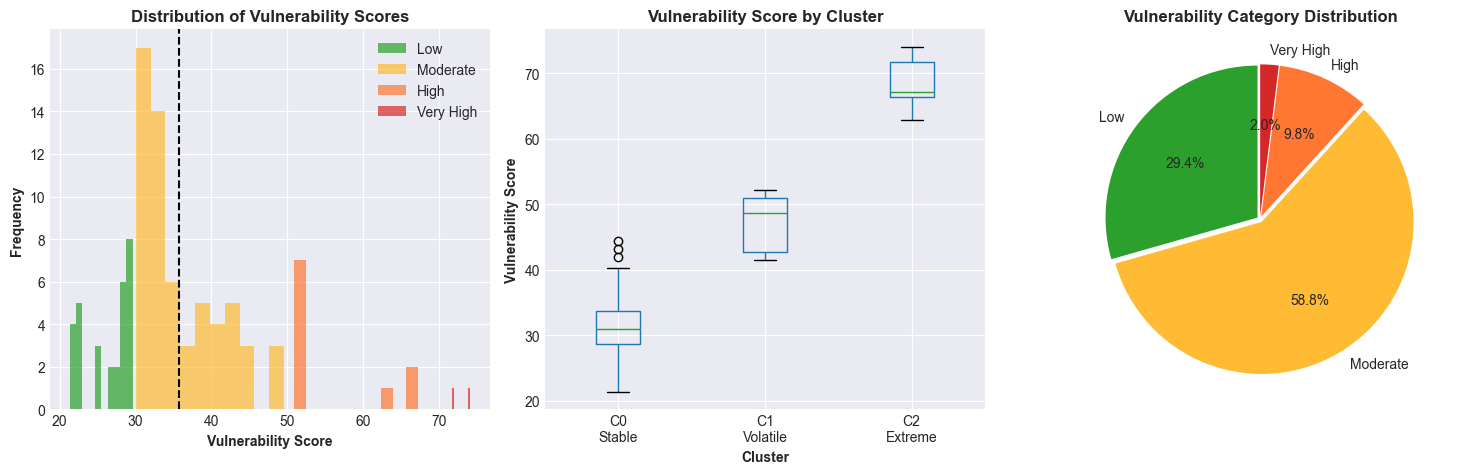

Figure saved: results/figures/vulnerability_score_distribution.png


In [17]:
# Cell 8: Vulnerability Score Distribution Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Histogram of vulnerability scores
ax1 = axes[0]
colors_vuln = {'Low': '#2ca02c', 'Moderate': '#ffbb33', 'High': '#ff7733', 'Very High': '#d62728'}
for cat in ['Low', 'Moderate', 'High', 'Very High']:
    data = df[df['vulnerability_category'] == cat]['vulnerability_score']
    if len(data) > 0:
        ax1.hist(data, bins=10, alpha=0.7, label=cat, color=colors_vuln[cat])
ax1.set_xlabel('Vulnerability Score', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Distribution of Vulnerability Scores', fontweight='bold')
ax1.legend()
ax1.axvline(df['vulnerability_score'].mean(), color='black', linestyle='--', label='Mean')

# Plot 2: Boxplot by cluster
ax2 = axes[1]
cluster_labels = [f"C{i}\n{cluster_names[i].split()[0]}" for i in sorted(df['cluster_final'].unique())]
bp = df.boxplot(column='vulnerability_score', by='cluster_final', ax=ax2, 
                positions=range(len(cluster_labels)))
ax2.set_xticklabels(cluster_labels)
ax2.set_xlabel('Cluster', fontweight='bold')
ax2.set_ylabel('Vulnerability Score', fontweight='bold')
ax2.set_title('Vulnerability Score by Cluster', fontweight='bold')
plt.suptitle('')

# Plot 3: Category pie chart
ax3 = axes[2]
cat_counts = df['vulnerability_category'].value_counts().sort_index()
colors_pie = [colors_vuln[c] for c in cat_counts.index]
ax3.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', colors=colors_pie,
        explode=[0.02]*len(cat_counts), startangle=90)
ax3.set_title('Vulnerability Category Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/vulnerability_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/vulnerability_score_distribution.png")

## 4. Policy Targeting Scenarios

Simulasi skenario targeting berbasis cluster untuk berbagai tingkat anggaran.

In [18]:
# Cell 9: Define Targeting Scenarios
print("=" * 80)
print("POLICY TARGETING SCENARIOS")
print("=" * 80)
print("\nAsumsi: Targeting berbasis cluster membership untuk program bantuan sosial")

scenarios = {
    'Scenario A: Target Extreme Only': {
        'clusters': [2],
        'description': 'Only target Cluster 2 (highest vulnerability)'
    },
    'Scenario B: Target High + Extreme': {
        'clusters': [1, 2],
        'description': 'Target Cluster 1 and 2 (volatile + extreme)'
    },
    'Scenario C: Universal (All Clusters)': {
        'clusters': [0, 1, 2],
        'description': 'Universal coverage - all clusters'
    },
    'Scenario D: Score-based (Top 30%)': {
        'threshold': df['vulnerability_score'].quantile(0.70),
        'description': 'Target top 30% by vulnerability score'
    }
}

results = []
total_obs = len(df)

for name, config in scenarios.items():
    if 'clusters' in config:
        targeted = df[df['cluster_final'].isin(config['clusters'])]
    else:
        targeted = df[df['vulnerability_score'] >= config['threshold']]
    
    n_targeted = len(targeted)
    pct_targeted = n_targeted / total_obs * 100
    avg_vuln = targeted['vulnerability_score'].mean() if len(targeted) > 0 else 0
    
    results.append({
        'Scenario': name,
        'Description': config['description'],
        'N Targeted': n_targeted,
        '% Coverage': pct_targeted,
        'Avg Vuln Score': avg_vuln
    })
    
    print(f"\n{name}")
    print(f"  {config['description']}")
    print(f"  Households targeted: {n_targeted} ({pct_targeted:.1f}%)")
    print(f"  Average vulnerability score: {avg_vuln:.1f}")

POLICY TARGETING SCENARIOS

Asumsi: Targeting berbasis cluster membership untuk program bantuan sosial

Scenario A: Target Extreme Only
  Only target Cluster 2 (highest vulnerability)
  Households targeted: 5 (4.9%)
  Average vulnerability score: 68.5

Scenario B: Target High + Extreme
  Target Cluster 1 and 2 (volatile + extreme)
  Households targeted: 23 (22.5%)
  Average vulnerability score: 51.7

Scenario C: Universal (All Clusters)
  Universal coverage - all clusters
  Households targeted: 102 (100.0%)
  Average vulnerability score: 35.7

Scenario D: Score-based (Top 30%)
  Target top 30% by vulnerability score
  Households targeted: 31 (30.4%)
  Average vulnerability score: 48.9


In [19]:
# Cell 10: Scenario Comparison Table
scenario_df = pd.DataFrame(results)

print("=" * 80)
print("SCENARIO COMPARISON SUMMARY")
print("=" * 80)
print(scenario_df.to_string(index=False))

# Calculate efficiency ratio (avg vulnerability per % coverage)
scenario_df['Efficiency'] = scenario_df['Avg Vuln Score'] / (scenario_df['% Coverage'] / 100)

print("\n" + "-" * 40)
print("Efficiency Analysis (Vuln Score per % Coverage):")
print("-" * 40)
for _, row in scenario_df.iterrows():
    print(f"  {row['Scenario'].split(':')[1].strip()}: {row['Efficiency']:.2f}")

SCENARIO COMPARISON SUMMARY
                            Scenario                                   Description  N Targeted  % Coverage  Avg Vuln Score
     Scenario A: Target Extreme Only Only target Cluster 2 (highest vulnerability)           5    4.901961       68.462528
   Scenario B: Target High + Extreme   Target Cluster 1 and 2 (volatile + extreme)          23   22.549020       51.722848
Scenario C: Universal (All Clusters)             Universal coverage - all clusters         102  100.000000       35.710825
   Scenario D: Score-based (Top 30%)         Target top 30% by vulnerability score          31   30.392157       48.863457

----------------------------------------
Efficiency Analysis (Vuln Score per % Coverage):
----------------------------------------
  Target Extreme Only: 1396.64
  Target High + Extreme: 229.38
  Universal (All Clusters): 35.71
  Score-based (Top 30%): 160.78


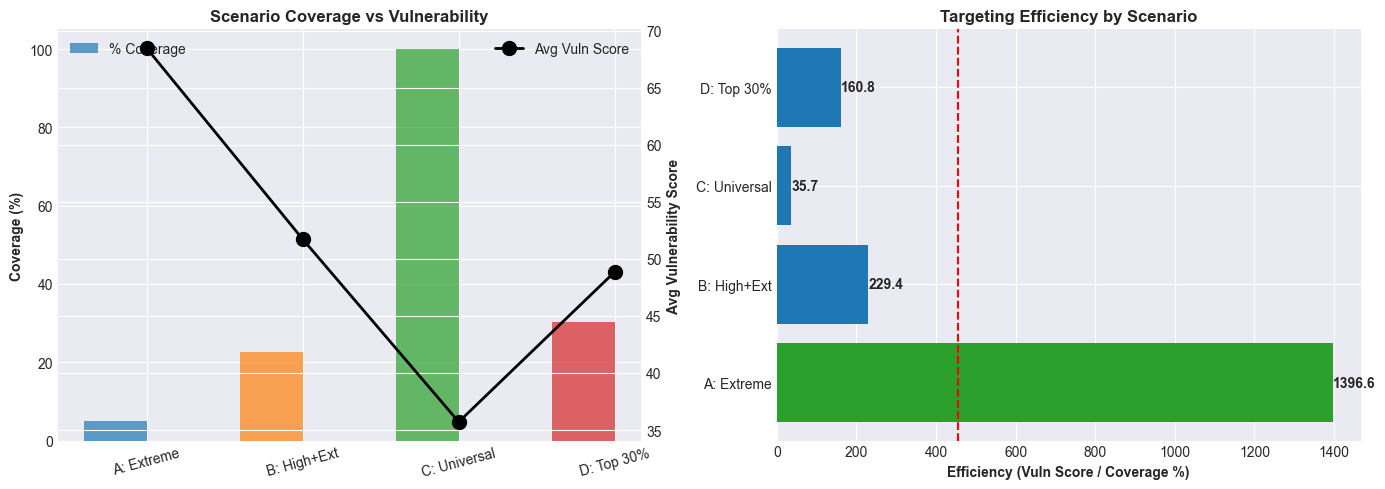

Figure saved: results/figures/targeting_scenarios.png


In [20]:
# Cell 11: Scenario Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Coverage vs Vulnerability Score
ax1 = axes[0]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
x_pos = range(len(scenario_df))
bars1 = ax1.bar([x - 0.2 for x in x_pos], scenario_df['% Coverage'], 0.4, 
                label='% Coverage', color=colors, alpha=0.7)
ax1_twin = ax1.twinx()
line1 = ax1_twin.plot(x_pos, scenario_df['Avg Vuln Score'], 'ko-', 
                       markersize=10, linewidth=2, label='Avg Vuln Score')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['A: Extreme', 'B: High+Ext', 'C: Universal', 'D: Top 30%'], rotation=15)
ax1.set_ylabel('Coverage (%)', fontweight='bold')
ax1_twin.set_ylabel('Avg Vulnerability Score', fontweight='bold')
ax1.set_title('Scenario Coverage vs Vulnerability', fontweight='bold')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Plot 2: Efficiency comparison
ax2 = axes[1]
efficiency_colors = ['#2ca02c' if e == scenario_df['Efficiency'].max() else '#1f77b4' 
                     for e in scenario_df['Efficiency']]
bars2 = ax2.barh(range(len(scenario_df)), scenario_df['Efficiency'], color=efficiency_colors)
ax2.set_yticks(range(len(scenario_df)))
ax2.set_yticklabels(['A: Extreme', 'B: High+Ext', 'C: Universal', 'D: Top 30%'])
ax2.set_xlabel('Efficiency (Vuln Score / Coverage %)', fontweight='bold')
ax2.set_title('Targeting Efficiency by Scenario', fontweight='bold')
ax2.axvline(scenario_df['Efficiency'].mean(), color='red', linestyle='--', label='Mean')
for i, (bar, val) in enumerate(zip(bars2, scenario_df['Efficiency'])):
    ax2.text(val + 1, i, f'{val:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/targeting_scenarios.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/targeting_scenarios.png")

## 5. Cluster-based Policy Recommendations

In [21]:
# Cell 12: Generate Policy Recommendations by Cluster
print("=" * 80)
print("CLUSTER-BASED POLICY RECOMMENDATIONS")
print("=" * 80)

# Get cluster characteristics
cluster_chars = df.groupby('cluster_final').agg({
    'cv_consumption': 'mean',
    'food_ratio': 'mean',
    'nonfood_ratio': 'mean',
    'vulnerability_score': 'mean'
}).round(3)

recommendations = {
    0: {
        'priority': 'LOW',
        'rationale': 'Stable consumption patterns, low volatility',
        'policy': [
            'Monitoring: Periodic assessment to detect changes',
            'Prevention: Financial literacy programs',
            'Focus: Maintain stability, prevent deterioration'
        ]
    },
    1: {
        'priority': 'HIGH',
        'rationale': 'High consumption volatility, elevated food ratio',
        'policy': [
            'Income smoothing: Employment/livelihood programs',
            'Safety net: Priority for social assistance',
            'Focus: Reduce consumption volatility'
        ]
    },
    2: {
        'priority': 'CRITICAL',
        'rationale': 'Extreme volatility, highest vulnerability score',
        'policy': [
            'Emergency support: Immediate cash/food assistance',
            'Intensive case management: Individual support',
            'Focus: Crisis stabilization and recovery'
        ]
    }
}

for cluster, rec in recommendations.items():
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster}: {cluster_names[cluster]}")
    print(f"{'='*60}")
    print(f"  Priority Level: {rec['priority']}")
    print(f"  Rationale: {rec['rationale']}")
    print(f"\n  Recommended Policies:")
    for policy in rec['policy']:
        print(f"    - {policy}")

CLUSTER-BASED POLICY RECOMMENDATIONS

CLUSTER 0: Stable (Low Volatility)
  Priority Level: LOW
  Rationale: Stable consumption patterns, low volatility

  Recommended Policies:
    - Monitoring: Periodic assessment to detect changes
    - Prevention: Financial literacy programs
    - Focus: Maintain stability, prevent deterioration

CLUSTER 1: Volatile (High CV)
  Priority Level: HIGH
  Rationale: High consumption volatility, elevated food ratio

  Recommended Policies:
    - Income smoothing: Employment/livelihood programs
    - Safety net: Priority for social assistance
    - Focus: Reduce consumption volatility

CLUSTER 2: Extreme (Very High CV)
  Priority Level: CRITICAL
  Rationale: Extreme volatility, highest vulnerability score

  Recommended Policies:
    - Emergency support: Immediate cash/food assistance
    - Intensive case management: Individual support
    - Focus: Crisis stabilization and recovery


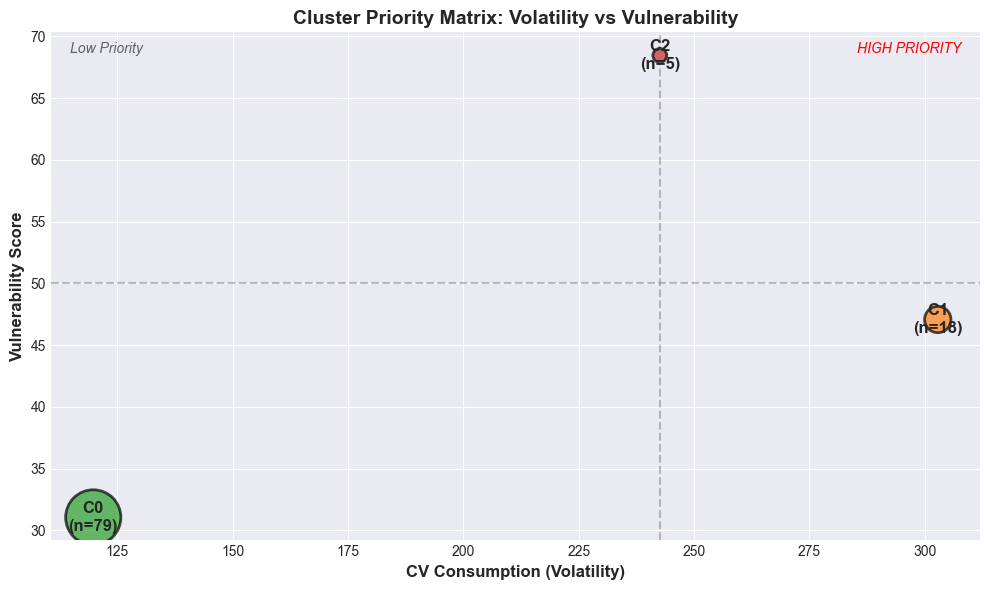

Figure saved: results/figures/cluster_priority_matrix.png


In [22]:
# Cell 13: Priority Matrix Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Create priority matrix
priority_data = df.groupby('cluster_final').agg({
    'cv_consumption': 'mean',
    'vulnerability_score': 'mean'
}).reset_index()

priority_data['size'] = df.groupby('cluster_final').size().values
priority_data['label'] = [f"C{i}\n(n={n})" for i, n in zip(priority_data['cluster_final'], priority_data['size'])]

colors_priority = {0: '#2ca02c', 1: '#ff7f0e', 2: '#d62728'}
scatter_colors = [colors_priority[c] for c in priority_data['cluster_final']]

scatter = ax.scatter(priority_data['cv_consumption'], 
                     priority_data['vulnerability_score'],
                     s=priority_data['size'] * 20,
                     c=scatter_colors,
                     alpha=0.7, edgecolors='black', linewidth=2)

for i, row in priority_data.iterrows():
    ax.annotate(row['label'], (row['cv_consumption'], row['vulnerability_score']),
                fontsize=12, fontweight='bold', ha='center', va='center')

ax.set_xlabel('CV Consumption (Volatility)', fontsize=12, fontweight='bold')
ax.set_ylabel('Vulnerability Score', fontsize=12, fontweight='bold')
ax.set_title('Cluster Priority Matrix: Volatility vs Vulnerability', fontsize=14, fontweight='bold')

# Add quadrant labels
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=priority_data['cv_consumption'].median(), color='gray', linestyle='--', alpha=0.5)
ax.text(0.02, 0.98, 'Low Priority', transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', style='italic', alpha=0.7)
ax.text(0.98, 0.98, 'HIGH PRIORITY', transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', horizontalalignment='right', style='italic', color='red')

plt.tight_layout()
plt.savefig('../results/figures/cluster_priority_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/cluster_priority_matrix.png")

## 6. Summary & Export Results

In [23]:
# Cell 14: Export Vulnerability Scores
output_cols = ['year', 'expenditure_bracket', 'cluster_final', 
               'cv_consumption', 'food_ratio', 'nonfood_ratio',
               'vulnerability_score', 'vulnerability_category']

output_df = df[output_cols].copy()
output_df.to_csv('../data/vulnerability_scores.csv', index=False)

print("=" * 80)
print("VULNERABILITY SCORES EXPORTED")
print("=" * 80)
print(f"File: data/vulnerability_scores.csv")
print(f"Shape: {output_df.shape}")
print(f"\nSample data:")
print(output_df.head(10).to_string(index=False))

VULNERABILITY SCORES EXPORTED
File: data/vulnerability_scores.csv
Shape: (102, 8)

Sample data:
 year expenditure_bracket  cluster_final  cv_consumption  food_ratio  nonfood_ratio  vulnerability_score vulnerability_category
 2013 1 000 000 dan lebih              0      105.047721   34.283466      65.716534            21.350833                    Low
 2013    100 000- 149 999              0      157.832118   69.671589      30.328411            42.015617               Moderate
 2013    150 000- 199 999              0      137.993248   67.472204      32.527796            39.158048               Moderate
 2013    200 000- 299 999              0      120.409231   66.082762      33.917238            36.872897               Moderate
 2013    300 000- 499 999              0      107.956826   62.003612      37.996388            33.885851               Moderate
 2013    500 000- 749 999              0      102.488263   56.509962      43.490038            30.936825               Moderate
 2013   

In [24]:
# Cell 15: Final Summary
print("=" * 80)
print("NOTEBOOK 08 SUMMARY: POLICY TARGETING FRAMEWORK")
print("=" * 80)

print("\n1. VULNERABILITY SCORING SYSTEM")
print("   - Composite score berbasis 4 komponen:")
print("     * Cluster membership (40%)")
print("     * CV consumption (25%)")
print("     * Food ratio (20%)")
print("     * Non-food ratio (15%)")
print(f"   - Score range: {df['vulnerability_score'].min():.1f} - {df['vulnerability_score'].max():.1f}")

print("\n2. TARGETING SCENARIOS")
print("   - Scenario A (Extreme only): Highest efficiency, lowest coverage")
print("   - Scenario B (High + Extreme): Balanced approach")
print("   - Scenario C (Universal): Full coverage, lowest efficiency")
print("   - Scenario D (Top 30%): Score-based targeting")

print("\n3. POLICY RECOMMENDATIONS BY CLUSTER")
print("   - Cluster 0 (Stable): Monitoring & prevention")
print("   - Cluster 1 (Volatile): Income smoothing & safety nets")
print("   - Cluster 2 (Extreme): Emergency support & case management")

print("\n4. OUTPUTS GENERATED")
print("   - data/vulnerability_scores.csv")
print("   - figures/vulnerability_score_distribution.png")
print("   - figures/targeting_scenarios.png")
print("   - figures/cluster_priority_matrix.png")

print("\n" + "=" * 80)
print("METHODOLOGICAL NOTE")
print("=" * 80)
print("This framework demonstrates HOW cluster-based segmentation can inform")
print("social policy targeting. Since we use aggregate BPS data (not individual")
print("household data), we focus on FRAMEWORK DEVELOPMENT rather than measuring")
print("actual targeting accuracy (inclusion/exclusion errors).")
print("\nFor real-world implementation, individual-level data would be needed")
print("to calculate true targeting performance metrics.")

NOTEBOOK 08 SUMMARY: POLICY TARGETING FRAMEWORK

1. VULNERABILITY SCORING SYSTEM
   - Composite score berbasis 4 komponen:
     * Cluster membership (40%)
     * CV consumption (25%)
     * Food ratio (20%)
     * Non-food ratio (15%)
   - Score range: 21.4 - 74.1

2. TARGETING SCENARIOS
   - Scenario A (Extreme only): Highest efficiency, lowest coverage
   - Scenario B (High + Extreme): Balanced approach
   - Scenario C (Universal): Full coverage, lowest efficiency
   - Scenario D (Top 30%): Score-based targeting

3. POLICY RECOMMENDATIONS BY CLUSTER
   - Cluster 0 (Stable): Monitoring & prevention
   - Cluster 1 (Volatile): Income smoothing & safety nets
   - Cluster 2 (Extreme): Emergency support & case management

4. OUTPUTS GENERATED
   - data/vulnerability_scores.csv
   - figures/vulnerability_score_distribution.png
   - figures/targeting_scenarios.png
   - figures/cluster_priority_matrix.png

METHODOLOGICAL NOTE
This framework demonstrates HOW cluster-based segmentation can info